In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp './kaggle.json' '/root/.kaggle/'

In [ ]:
!kaggle datasets download --force -d 'zalando-research/fashionmnist'
!rm '/root/.kaggle/kaggle.json'

 83% 57.0M/68.8M [00:00<00:00, 46.7MB/s]
100% 68.8M/68.8M [00:01<00:00, 67.7MB/s]


In [ ]:
!unzip 'fashionmnist.zip' -d 'my_data'

Archive:  fashionmnist.zip
  inflating: my_data/fashion-mnist_test.csv  
  inflating: my_data/fashion-mnist_train.csv  
  inflating: my_data/t10k-images-idx3-ubyte  
  inflating: my_data/t10k-labels-idx1-ubyte  
  inflating: my_data/train-images-idx3-ubyte  
  inflating: my_data/train-labels-idx1-ubyte  


In [ ]:
%tensorflow_version 1.x
from keras.utils import to_categorical
import tensorflow as tf
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import*
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import tensorflow_hub as tfHub
from tensorflow.keras import layers as tfLayers
from sklearn.metrics import confusion_matrix, classification_report
import itertools

TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_dataset = pd.read_csv('./my_data/fashion-mnist_train.csv').values
test_dataset = pd.read_csv('./my_data/fashion-mnist_test.csv').values
train_data = pd.read_csv('./my_data/fashion-mnist_train.csv')
test_data = pd.read_csv('./my_data/fashion-mnist_test.csv')
num_train_examples = len(train_dataset)
num_test_examples = len(test_dataset)

In [ ]:
train_df = pd.read_csv('./my_data/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('./my_data/fashion-mnist_test.csv', sep = ',')

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


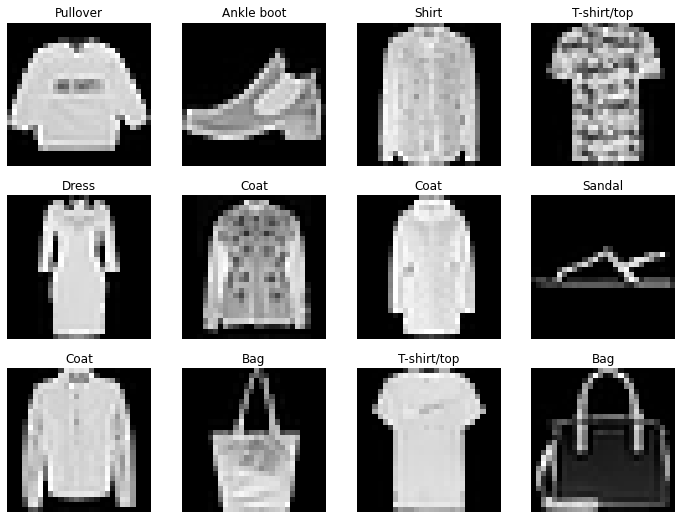

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']
num_classes = len(class_names)

plt.figure(figsize=(12,9))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    image_resized = np.resize(train_data.iloc[i,1:].values,(28,28))
    plt.title(class_names[train_data.iloc[i,0]])
    plt.imshow(image_resized, cmap='gray', interpolation='none')
    plt.axis('off')

In [ ]:
print('num_train: ',num_train_examples)
print('num_test: ',num_test_examples)
print('num_class: ',num_classes)

num_train:  60000
num_test:  10000
num_class:  10


In [ ]:
train_dataset_x = train_dataset[:,1:] / 255
train_dataset_x = train_dataset_x.reshape((num_train_examples, 28, 28, 1))
train_dataset_y = train_dataset[:,0]


test_dataset_x = test_dataset[:,1:] / 255
test_dataset_x = test_dataset_x.reshape((num_test_examples, 28, 28, 1))
test_dataset_y = test_dataset[:,0]

In [ ]:
train_dataset.shape,test_dataset.shape

((60000, 785), (10000, 785))

In [ ]:
train_Y_one_hot = to_categorical(train_dataset_y)
test_Y_one_hot = to_categorical(test_dataset_y)

In [ ]:
train_Y_one_hot.shape,test_Y_one_hot.shape

((60000, 10), (10000, 10))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_dataset_x, train_Y_one_hot, test_size=0.2, random_state=13)

In [ ]:
X_train.shape,y_train.shape

((48000, 28, 28, 1), (48000, 10))

In [ ]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)

])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

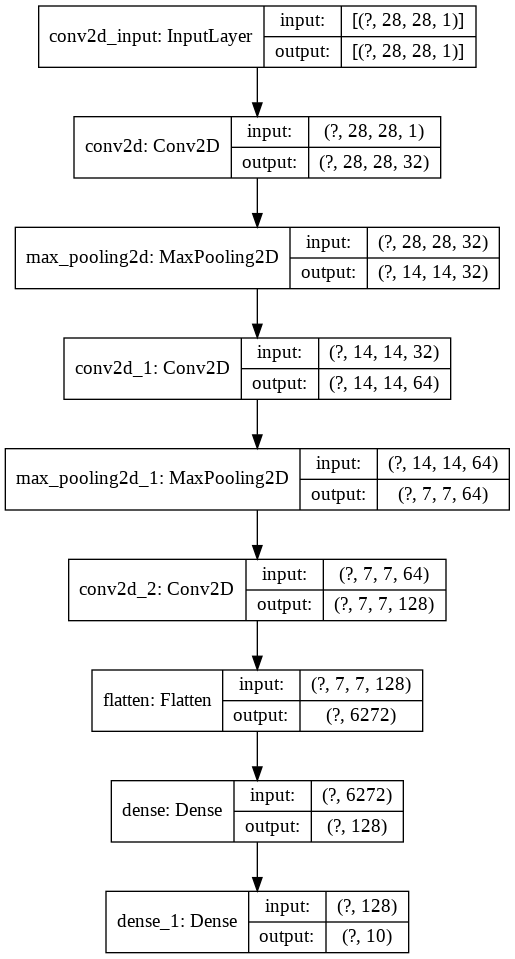

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model , 'classyfier.png' , show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=256,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 38s 786us/sample - loss: 0.5781 - acc: 0.7899 - val_loss: 0.3857 - val_acc: 0.8636
Epoch 2/30
48000/48000 [==============================] - 37s 778us/sample - loss: 0.3404 - acc: 0.8783 - val_loss: 0.3072 - val_acc: 0.8885
Epoch 3/30
48000/48000 [==============================] - 37s 776us/sample - loss: 0.2855 - acc: 0.8976 - val_loss: 0.2997 - val_acc: 0.8913
Epoch 4/30
48000/48000 [==============================] - 37s 778us/sample - loss: 0.2528 - acc: 0.9085 - val_loss: 0.2595 - val_acc: 0.9071
Epoch 5/30
48000/48000 [==============================] - 37s 775us/sample - loss: 0.2293 - acc: 0.9168 - val_loss: 0.2476 - val_acc: 0.9103
Epoch 6/30
48000/48000 [==============================] - 37s 780us/sample - loss: 0.2057 - acc: 0.9254 - val_loss: 0.2424 - val_acc: 0.9123
Epoch 7/30
48000/48000 [==============================] - 37s 780us/sample - loss: 0.1881 - acc: 0.9312 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [ ]:
plot_accuracy_and_loss(history)

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
score = model.evaluate(test_dataset_x, test_Y_one_hot)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

10000/10000 [==============================] - 3s 281us/sample - loss: 0.3834 - acc: 0.9231
Test loss: 0.3833569922352908
Test accuracy: 0.9231


In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)

])

In [ ]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_2.summary();  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)        

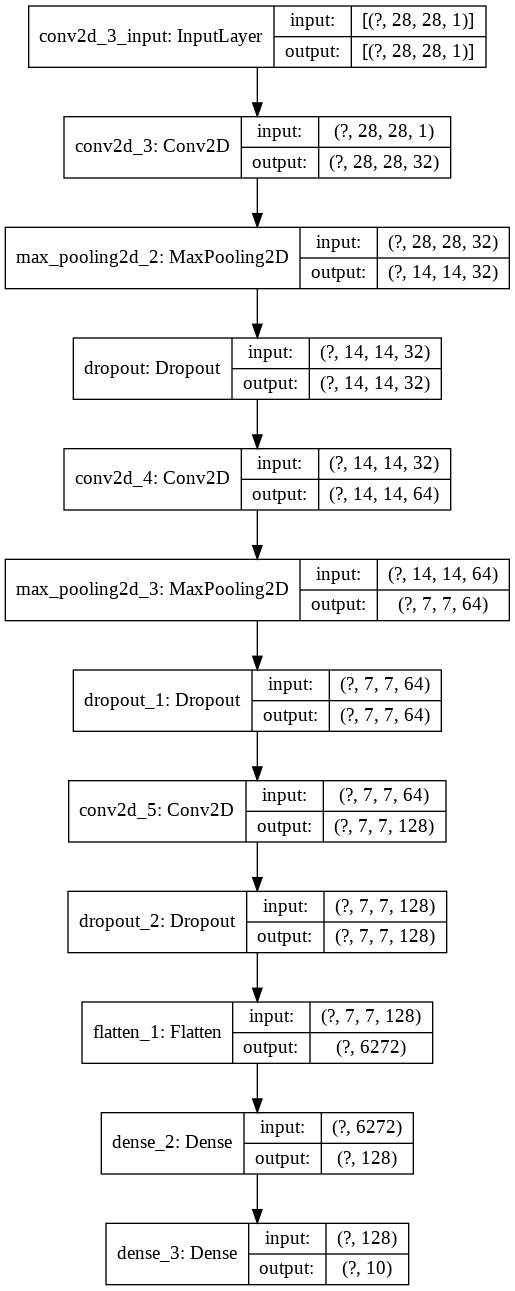

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_2 , 'classyfier.png' , show_shapes=True)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images
batches = datagen.flow(X_train, y_train, batch_size=256)

In [ ]:
print(len(batches))

188


In [ ]:
history3 = model_2.fit_generator(batches, steps_per_epoch=48000//256, epochs=30,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/30
187/187 [==============================] - 48s 255ms/step - loss: 0.9535 - acc: 0.6344 - val_loss: 0.6033 - val_acc: 0.7733
Epoch 2/30
187/187 [==============================] - 47s 252ms/step - loss: 0.6393 - acc: 0.7568 - val_loss: 0.5455 - val_acc: 0.8014
Epoch 3/30
187/187 [==============================] - 47s 251ms/step - loss: 0.5696 - acc: 0.7836 - val_loss: 0.4642 - val_acc: 0.8351
Epoch 4/30
187/187 [==============================] - 47s 250ms/step - loss: 0.5282 - acc: 0.8006 - val_loss: 0.4391 - val_acc: 0.8448
Epoch 5/30
187/187 [==============================] - 47s 252ms/step - loss: 0.4932 - acc: 0.8159 - val_loss: 0.3818 - val_acc: 0.8627
Epoch 6/30
187/187 [==============================] - 47s 251ms/step - loss: 0.4664 - acc: 0.8269 - val_loss: 0.3736 - val_acc: 0.8621
Epoch 7/30
187/187 [==============================] - 47s 250ms/step - loss: 0.4487 - acc: 0.8314 - val_loss: 0.3550 - val_acc: 0.8725
Epoch 8/30
187/187 [==============================] - 4

In [ ]:
plot_accuracy_and_loss(history3)

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

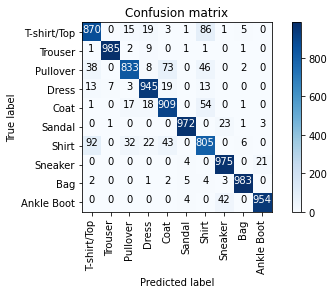

In [ ]:
x_test=test_dataset_x
y_test=test_Y_one_hot
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [ ]:
predicted_classes = model_2.predict_classes(x_test)
# get the indices to be plotted
y_true = test_dataset_y
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [ ]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9135
Incorrect predicted classes: 865


In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.85      0.85      0.85      1000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.91      0.85      0.88      1000
     Class 3       0.92      0.93      0.93      1000
     Class 4       0.88      0.85      0.86      1000
     Class 5       0.98      0.97      0.98      1000
     Class 6       0.72      0.76      0.74      1000
     Class 7       0.94      0.97      0.96      1000
     Class 8       0.98      0.99      0.99      1000
     Class 9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
score = model_2.evaluate(test_dataset_x, test_Y_one_hot)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 291us/sample - loss: 0.2286 - acc: 0.9135
Test loss: 0.22856730523705482
Test accuracy: 0.9135


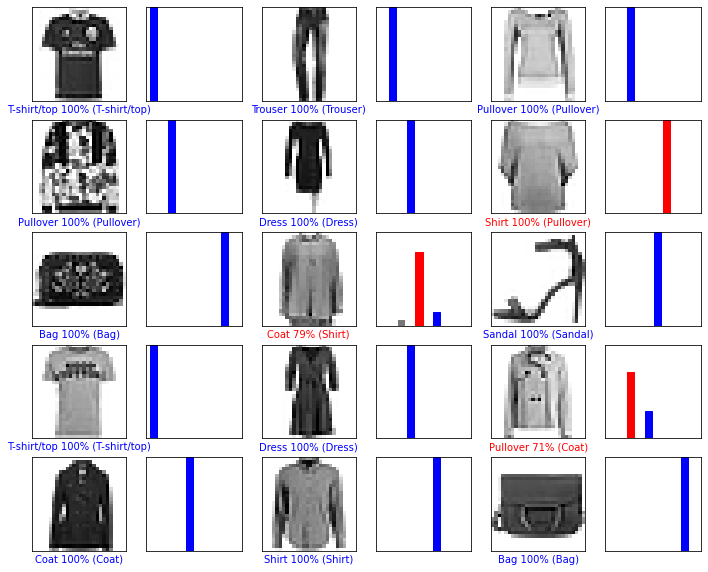

In [ ]:
predictions = model.predict(x_test)
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_dataset_y, test_dataset_x)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_dataset_y)